<a href="https://colab.research.google.com/github/AnHaiTrinh/handson-ml/blob/main/Sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sklearn

import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Basic RNNS

### Generate the dataset

In [ ]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
  return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

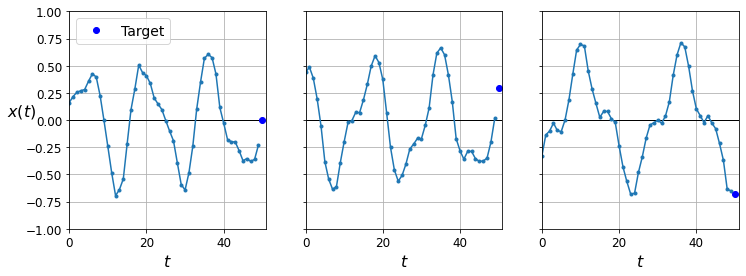

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))

### Computing some baselines

Naive predictions

In [ ]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_pred, y_valid))

0.020988882

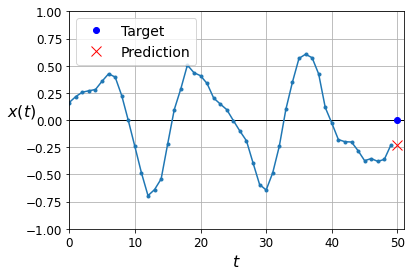

In [ ]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

Linear predictions

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.Flatten(input_shape=[n_steps, 1]),
                                 keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="SGD")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 7ms/step - loss: 0.0857 - val_loss: 0.0455
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0360 - val_loss: 0.0291
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0248 - val_loss: 0.0215
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0191 - val_loss: 0.0173
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0159 - val_loss: 0.0147
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0138 - val_loss: 0.0129
Epoch 7/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0117
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 10/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0099 - val_loss: 0.0095

In [ ]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0064


0.00641239620745182

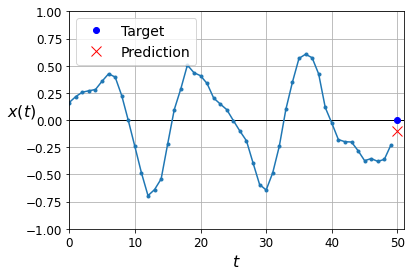

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

### Using RNN

Simple RNN

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 8s 34ms/step - loss: 0.8659 - val_loss: 0.6427
Epoch 2/5
219/219 [==============================] - 7s 34ms/step - loss: 0.3065 - val_loss: 0.1642
Epoch 3/5
219/219 [==============================] - 7s 33ms/step - loss: 0.1497 - val_loss: 0.1540
Epoch 4/5
219/219 [==============================] - 7s 34ms/step - loss: 0.1468 - val_loss: 0.1417
Epoch 5/5
219/219 [==============================] - 7s 33ms/step - loss: 0.1010 - val_loss: 0.0636


Text(0, 0.5, 'Loss')

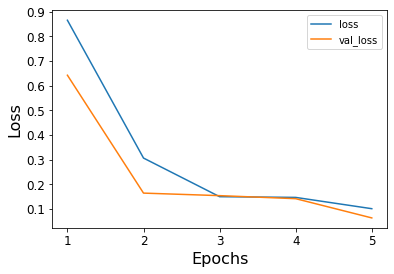

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.xticks(np.arange(5), np.arange(1, 6, 1))
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

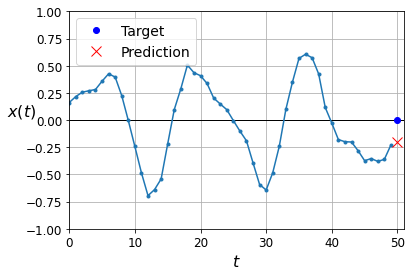

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

Deep RNN

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.SimpleRNN(20, return_sequences=True),
                                 keras.layers.SimpleRNN(1)
])
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 28s 123ms/step - loss: 0.0335 - val_loss: 0.0066
Epoch 2/20
219/219 [==============================] - 27s 123ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 3/20
219/219 [==============================] - 27s 124ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 4/20
219/219 [==============================] - 28s 129ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/20
219/219 [==============================] - 27s 121ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 6/20
219/219 [==============================] - 27s 123ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 7/20
219/219 [==============================] - 27s 125ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 8/20
219/219 [==============================] - 27s 121ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 9/20
219/219 [==============================] - 27s 122ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 10/20
219/219 [==============================] - 27s 122ms/step - l

In [ ]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 12ms/step - loss: 0.0032


0.0032069538719952106

Text(0, 0.5, 'Loss')

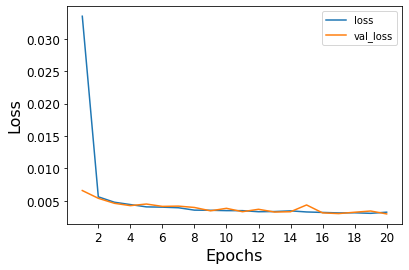

In [ ]:
pd.DataFrame(history.history).plot()
plt.xticks(np.arange(1, 20, 2), np.arange(2, 21, 2))
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

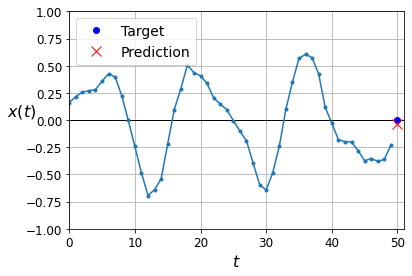

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.SimpleRNN(20),
                                 keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 18s 75ms/step - loss: 0.0589 - val_loss: 0.0073
Epoch 2/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 3/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 4/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 6/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 8/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 9/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 10/20
219/219 [==============================] - 16s 74ms/step - loss: 0.003

In [ ]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 9ms/step - loss: 0.0034


0.003372901352122426

Text(0, 0.5, 'Loss')

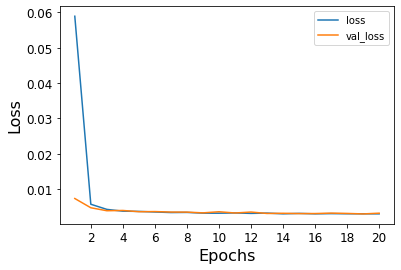

In [ ]:
pd.DataFrame(history.history).plot()
plt.xticks(np.arange(1, 20, 2), np.arange(2, 21, 2))
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

### Multiple steps prediction

Predicting using n previous timesteps 


In [ ]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

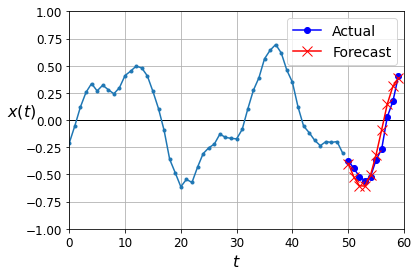

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
  plt.axis([0, n_steps + ahead, -1, 1])
  plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)

Predicting using all previous timesteps

In [ ]:
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, n_steps:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, n_steps:, 0]

In [ ]:
X = X_valid
for _ in range(10):
  y_pred_new = model.predict(X)[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_new], axis=1)

y_pred = X[:, n_steps:, 0]

In [ ]:
np.mean(keras.metrics.mean_squared_error(y_valid, y_pred))

0.034441482

In [ ]:
y_valid.shape

(2000, 10)

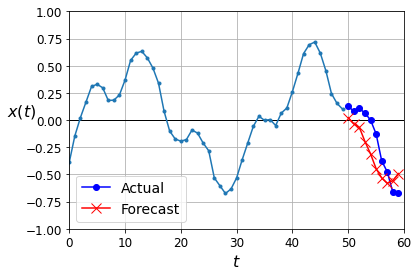

In [ ]:
plot_multiple_forecasts(X_valid, y_valid[..., np.newaxis], y_pred[..., np.newaxis])

Naive prediction

In [ ]:
naive_y_pred = np.tile(X_valid[:, -1], 10)
np.mean(keras.metrics.mean_squared_error(y_valid, naive_y_pred))

0.26502338

Linear prediction

In [ ]:
linear_model = keras.models.Sequential([
                                        keras.layers.Flatten(input_shape=[n_steps, 1]),
                                        keras.layers.Dense(10)
])
linear_model.compile(loss="mse", optimizer="adam")
linear_model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1230 - val_loss: 0.0614
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0482 - val_loss: 0.0423
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0368 - val_loss: 0.0351
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0318 - val_loss: 0.0312
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0287 - val_loss: 0.0286
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0266 - val_loss: 0.0267
Epoch 7/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0252
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0239 - val_loss: 0.0241
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0229 - val_loss: 0.0231
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0222 - val_loss: 0.0225

Predicting using RNN

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.SimpleRNN(20),
                                 keras.layers.Dense(10)
])
model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 20s 86ms/step - loss: 0.0639 - val_loss: 0.0358
Epoch 2/20
219/219 [==============================] - 21s 94ms/step - loss: 0.0304 - val_loss: 0.0239
Epoch 3/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0197 - val_loss: 0.0171
Epoch 4/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 5/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 6/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0125 - val_loss: 0.0111
Epoch 7/20
219/219 [==============================] - 19s 85ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 8/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 9/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0109 - val_loss: 0.0098
Epoch 10/20
219/219 [==============================] - 18s 83ms/step - loss: 0.010

In [ ]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

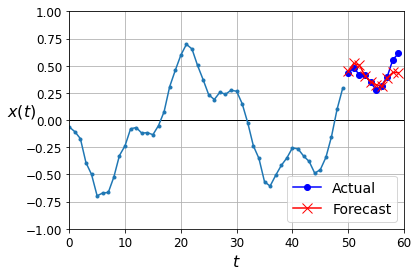

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

Predicting next 10 timesteps at once

In [ ]:
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 11):
  Y[..., step_ahead-1] = series[..., step_ahead:step_ahead+n_steps, 0]
y_train = Y[:7000]
y_valid = Y[7000:9000]
y_test = Y[9000:]

In [ ]:
model = keras.models.Sequential([
                                keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                                keras.layers.SimpleRNN(20, return_sequences=True),
                                keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
series = generate_time_series(1, 50 + 10)
X = series[:, :50, :]
y_true = series[:, 50:, 0]
y_pred = model.predict(X)[:, -1][..., np.newaxis]

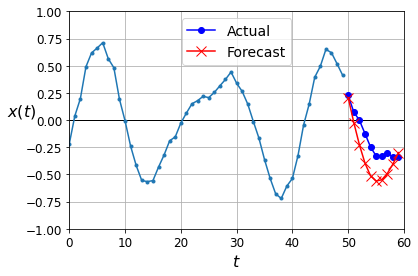

In [ ]:
plot_multiple_forecasts(X, y_true[..., np.newaxis], y_pred[..., np.newaxis])

## Deep RNN with BatchNorm

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.SimpleRNN(20, return_sequences=True),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 20s 83ms/step - loss: 0.1465 - last_time_step_mse: 0.1313 - val_loss: 0.0808 - val_last_time_step_mse: 0.0708
Epoch 2/20
219/219 [==============================] - 19s 85ms/step - loss: 0.0491 - last_time_step_mse: 0.0386 - val_loss: 0.0467 - val_last_time_step_mse: 0.0348
Epoch 3/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0426 - last_time_step_mse: 0.0321 - val_loss: 0.0410 - val_last_time_step_mse: 0.0301
Epoch 4/20
219/219 [==============================] - 18s 80ms/step - loss: 0.0384 - last_time_step_mse: 0.0273 - val_loss: 0.0378 - val_last_time_step_mse: 0.0261
Epoch 5/20
219/219 [==============================] - 18s 80ms/step - loss: 0.0355 - last_time_step_mse: 0.0240 - val_loss: 0.0350 - val_last_time_step_mse: 0.0225
Epoch 6/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0334 - last_time_step_mse: 0.0215 - val_loss: 0.0329 - val_last_time_step_mse: 0.0203
Epoch 7/20
219/2

## Deep RNN with LayerNorm

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 41s 169ms/step - loss: 0.1262 - last_time_step_mse: 0.1211 - val_loss: 0.0631 - val_last_time_step_mse: 0.0509
Epoch 2/20
219/219 [==============================] - 36s 166ms/step - loss: 0.0581 - last_time_step_mse: 0.0494 - val_loss: 0.0546 - val_last_time_step_mse: 0.0434
Epoch 3/20
219/219 [==============================] - 36s 167ms/step - loss: 0.0516 - last_time_step_mse: 0.0424 - val_loss: 0.0491 - val_last_time_step_mse: 0.0382
Epoch 4/20
219/219 [==============================] - 36s 165ms/step - loss: 0.0464 - last_time_step_mse: 0.0362 - val_loss: 0.0440 - val_last_time_step_mse: 0.0317
Epoch 5/20
219/219 [==============================] - 36s 165ms/step - loss: 0.0413 - last_time_step_mse: 0.0297 - val_loss: 0.0395 - val_last_time_step_mse: 0.0267
Epoch 6/20
219/219 [==============================] - 36s 165ms/step - loss: 0.0380 - last_time_step_mse: 0.0256 - val_loss: 0.0370 - val_last_time_step_mse: 0.0232
Epoch 7/20

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, activation=None, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.LayerNormalization(),
                                 keras.layers.Activation("tanh"),
                                 keras.layers.SimpleRNN(20, activation=None, return_sequences=True),
                                 keras.layers.LayerNormalization(),
                                 keras.layers.Activation("tanh"),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 19s 79ms/step - loss: 0.1537 - last_time_step_mse: 0.1391 - val_loss: 0.0592 - val_last_time_step_mse: 0.0431
Epoch 2/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0494 - last_time_step_mse: 0.0353 - val_loss: 0.0438 - val_last_time_step_mse: 0.0287
Epoch 3/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0408 - last_time_step_mse: 0.0265 - val_loss: 0.0392 - val_last_time_step_mse: 0.0241
Epoch 4/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0372 - last_time_step_mse: 0.0232 - val_loss: 0.0360 - val_last_time_step_mse: 0.0211
Epoch 5/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0348 - last_time_step_mse: 0.0213 - val_loss: 0.0342 - val_last_time_step_mse: 0.0202
Epoch 6/20
219/219 [==============================] - 17s 76ms/step - loss: 0.0328 - last_time_step_mse: 0.0196 - val_loss: 0.0325 - val_last_time_step_mse: 0.0177
Epoch 7/20
219/2

## One dimensional convolution

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.Conv1D(20, kernel_size=4, strides=2, padding="VALID",
                                                     input_shape=[None, 1]),
                                 keras.layers.GRU(20, return_sequences=True),
                                 keras.layers.GRU(20, return_sequences=True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, y_train[:, 3::2], epochs=20, validation_data=(X_valid, y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 12s 9ms/step - loss: 0.0674 - last_time_step_mse: 0.0588 - val_loss: 0.0506 - val_last_time_step_mse: 0.0406
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0408 - last_time_step_mse: 0.0335 - val_loss: 0.0347 - val_last_time_step_mse: 0.0254
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0311 - last_time_step_mse: 0.0222 - val_loss: 0.0278 - val_last_time_step_mse: 0.0166
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0263 - last_time_step_mse: 0.0154 - val_loss: 0.0255 - val_last_time_step_mse: 0.0139
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0243 - last_time_step_mse: 0.0132 - val_loss: 0.0238 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0232 - last_time_step_mse: 0.0124 - val_loss: 0.0229 - val_last_time_step_mse: 0.0116
Epoch 7/20
219/219 [=======

## WaveNet

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
  model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", dilation_rate=rate, activation="relu"))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0672 - last_time_step_mse: 0.0556 - val_loss: 0.0366 - val_last_time_step_mse: 0.0223
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0333 - last_time_step_mse: 0.0202 - val_loss: 0.0321 - val_last_time_step_mse: 0.0181
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0299 - last_time_step_mse: 0.0171 - val_loss: 0.0293 - val_last_time_step_mse: 0.0162
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0276 - last_time_step_mse: 0.0151 - val_loss: 0.0265 - val_last_time_step_mse: 0.0133
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0263 - last_time_step_mse: 0.0141 - val_loss: 0.0256 - val_last_time_step_mse: 0.0131
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0252 - last_time_step_mse: 0.0131 - val_loss: 0.0250 - val_last_time_step_mse: 0.0122
Epoch 7/20
219/219 [========

In [ ]:
class GatedActivationUnit(keras.layers.Layer):
  def __init__(self, activation="tanh", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
  def call(self, inputs):
    n_filters = inputs.shape[-1] // 2
    linear_output = inputs[..., :n_filters]
    gate = keras.activations.sigmoid(inputs[..., n_filters:])
    return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
  z = keras.layers.Conv1D(filters=2*n_filters, kernel_size=2, padding="causal", dilation_rate=dilation_rate, activation='relu')(inputs)
  z = GatedActivationUnit()(z)
  z = keras.layers.Conv1D(filters=n_filters, kernel_size=1)(z)
  return keras.layers.Add()([z, inputs]), z

In [ ]:
keras.backend.clear_session()

n_layers_per_block = 3
n_blocks = 1
n_filters = 32
n_outputs = 10

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(filters=n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
  z, skip = wavenet_residual_block(z, n_filters, rate)
  skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(filters=n_filters, kernel_size=1, activation="relu")(z)
outputs = keras.layers.Conv1D(filters=n_outputs, kernel_size=1, activation="softmax")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 3s 8ms/step - loss: 0.1210 - last_time_step_mse: 0.1161 - val_loss: 0.1208 - val_last_time_step_mse: 0.1126
Epoch 2/5
219/219 [==============================] - 2s 7ms/step - loss: 0.1209 - last_time_step_mse: 0.1160 - val_loss: 0.1206 - val_last_time_step_mse: 0.1125
Epoch 3/5
219/219 [==============================] - 2s 7ms/step - loss: 0.1208 - last_time_step_mse: 0.1159 - val_loss: 0.1205 - val_last_time_step_mse: 0.1124
Epoch 4/5
219/219 [==============================] - 1s 7ms/step - loss: 0.1207 - last_time_step_mse: 0.1158 - val_loss: 0.1204 - val_last_time_step_mse: 0.1122
Epoch 5/5
219/219 [==============================] - 1s 7ms/step - loss: 0.1206 - last_time_step_mse: 0.1157 - val_loss: 0.1203 - val_last_time_step_mse: 0.1122
